In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import pytorch_lightning as pl

## Defining the desired RBF Piecewise function

This section is still incomplete. While the skeleton of the RBF activation function has been defined, there are a few other features that are needed before we can see if this allows a single layer to learn the XOR function or not:

1. Put into a pytorch function (to enable backpropagation)
2. Put into a module to allow the threshold (and ep2?) parameters to be trainable
3. Consider making a trainable parameter for the left side of the RBF.

In [4]:
def rbf(x, eps=1):
    """Calculate the 1D gaussian RBF at x given an epsilon"""
    return np.exp(-(eps * x)**2)

def drbf(x, eps=1):
    """Calculate the derivative of a 1D gaussian RBF at x given an epsilon"""
    return (-2 * eps**2 * x) * np.exp(-(eps*x)**2)

def T2eps(T, s=0.001):
    """Calculate the epsilon needed such that rbf(T, eps) = s
    
    's' is a small number approximately 0 and T is the value at w"""
    return 1/(2*T) * np.log(1/s)

def xor_ap(x):
    """Calculate an action potential that can learn XOR.
    
    Main parameters:
    - T : The threshold for the activation function
    """
    T = 1
    if x < T:
        ep1 = T2eps(T)
        out = rbf(x-T, ep1) 
        return out
    else:
        out = rbf(x-T)
        return rbf(x-T)

In [5]:
from torch.autograd import Function
from torch.nn import functional as F

class PiecewiseRBF(Function):
    @staticmethod
    def forward(ctx, input, ep1, ep2):
        return torch.exp(-(ep1 * input)**2)
    
    @staticmethod
    def backward(ctx, input):
        pass

## Creating the XOR Dataset

The XOR function is simply defined as True only when the inputs are (False, True) or (True, False). In a continuous function, it can be defined as True only if, given an input (x1, x2), the signs of x1 and x2 are different.

This section is almost complete.

1. Can the `xor` function be simplified by vectorizing the simple operation by row?

In [6]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import random

%matplotlib inline

In [7]:
def xor(x):
    """Given a 2D tensor x, return 1 if x[0] has different sign than x[1], otherwise return 0"""
    assert len(x.shape) == 2, "Expects 2 dimensional tensor!"
    assert x.shape[1] == 2, "Expect only 2 columns!"
    return torch.eq(torch.sign(x[:,0]) * torch.sign(x[:, 1]), -1)

In [8]:
def create_xor_dataset(N, seed=42):
    torch.manual_seed(seed)
    x = 2*torch.rand(N, 2) - 1
    y = xor(x).float().reshape((-1, 1))
    return x,y

def plot_xor_ds(x, y):
    plt.scatter(x[:,0].detach().numpy(), x[:,1].detach().numpy(), c=y.detach().numpy())
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Generated XOR dataset")
    plt.show()

    
class XORDataset():
    def __init__(self, N, seed=42):
        self.X, self.Y = create_xor_dataset(N, seed)
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.Y[idx]
    
    def plot(self):
        plot_xor_ds(self.X, self.Y.flatten())


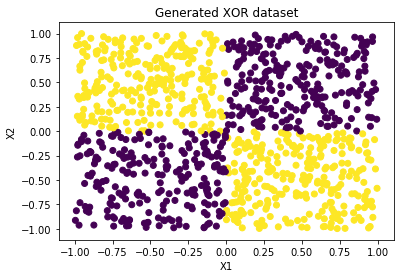

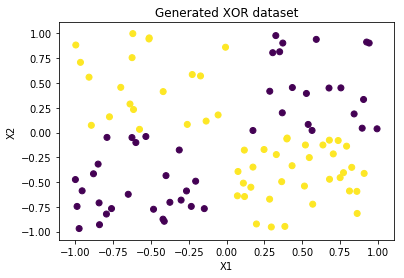

In [9]:
# Base X and Y
X = torch.tensor([
    [0., 0.],
    [0., 1.],
    [1., 0.],
    [1., 1.]])
Y = torch.tensor([
    [0.],
    [1.],
    [1.],
    [0.]])

# Larger dataset
ds_train = XORDataset(1000, 33)
ds_test = XORDataset(100, 32)

ds_train.plot()
ds_test.plot()

## Setting up pytorch-lightning

In [234]:
pl.LightningModule.validation_step??

In [228]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import pytorch_lightning as pl
    
def create_mod_list(init_dim, out_dim, hdims, activation, final_act=nn.Sigmoid()):
    if len(hdims) == 0:
        return nn.Sequential(*[nn.Linear(init_dim, out_dim), final_act])
    
    mod_list = [nn.Linear(init_dim, hdims[0]), activation]
    
    for i in range(len(hdims) - 1):
        ind = i + 1
        mod_list += [nn.Linear(hdims[i], hdims[ind]), activation]
        
    mod_list += [nn.Linear(hdims[-1], out_dim), final_act]
    return nn.Sequential(*mod_list)

def plot_model(model, X, y):
    cmap = plt.get_cmap("Paired")
    
    xs = np.linspace(-1.1, 1.1, 100)
    ys = np.linspace(-1.1, 1.1, 100)
    xx, yy = np.meshgrid(xs, ys)
    input = torch.tensor([xx.ravel(), yy.ravel()]).T.float()
    z = model.forward(input).reshape(xx.shape).detach()
    z[z < 0.5] = 0
    z[z >= 0.5] = 1
    
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, lw=0)
    
    return fig, ax

    
class BaseMLP(pl.LightningModule):
    def __init__(self, hdims, activation, final_act=nn.Sigmoid(), seed=42):
        """
        Parameters:
        ===========
        - hdims (List[int]): Hidden dimensions for each layer
        """
        super().__init__()
        
        self.layers = create_mod_list(2, 1, hdims, activation, final_act)
        self.loss = nn.MSELoss()
        self.batch_size = 32
        self.seed = seed

    def forward(self, x):
        x = self.layers(x)
        return x

    def training_step(self, batch, batch_nb):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        return {'loss': self.loss(y_hat, y)}

    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': self.loss(y_hat, y)}

    def validation_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        return {'avg_val_loss': avg_loss}

    def test_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self.forward(x)
        return {'test_loss': self.loss(y_hat, y)}

    def test_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        return {'avg_test_loss': avg_loss}

    def configure_optimizers(self):
        # REQUIRED
#         return torch.optim.SGD(self.parameters(), lr=0.002, momentum=0.9)
        return torch.optim.Adam(self.parameters(), lr=0.02)

    @pl.data_loader
    def train_dataloader(self):
        return DataLoader(XORDataset(1000, self.seed), batch_size=32, shuffle=True)

    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        # can also return a list of val dataloaders
        return DataLoader(XORDataset(200, self.seed), batch_size=64, shuffle=False)

    @pl.data_loader
    def test_dataloader(self):
        # OPTIONAL
        # can also return a list of test dataloaders
        return DataLoader(XORDataset(100, self.seed), batch_size=64, shuffle=False)


INFO:root:       Name        Type Params
0    layers  Sequential  401  
1  layers.0      Linear  300  
2  layers.1        ReLU    0  
3  layers.2      Linear  101  
4  layers.3     Sigmoid    0  
5      loss     MSELoss    0  
Epoch 3: 100%|██████████| 36/36 [00:00<00:00, 302.00batch/s, batch_nb=31, loss=0.060, v_nb=102]


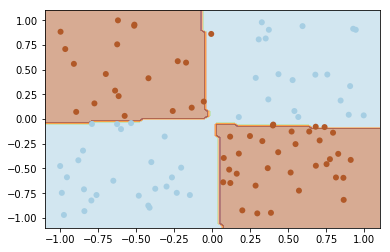

In [232]:
from pytorch_lightning import Trainer

model = BaseMLP([100], nn.ReLU(), nn.Sigmoid())
trainer = Trainer()
trainer.fit(model)
labels = plot_model(model, ds_test.X, ds_test.Y.flatten())

## Path Forward

- Can a single layer perceptron (SLP) learn the XOR function with a sigmoid?
- Can a SLP learn the XOR with a ReLU
- Can a MLP learn the XOR?

- Can a SLP learn the XOR function with a hardcoded DoubleRBF activation function?
- Can a SLP learn the XOR function with a trainable DoubleRBF activation function?

Still to code:
- Plot the decision map of the trained model (in blue/red), under all the data points of the dataset
- Can I show a decision boundary?